# Setup

**Imports**

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from loadmydata.load_human_locomotion import (
    load_human_locomotion_dataset,
    get_code_list,
)

**Utility functions**

In [3]:
def fig_ax(figsize=(15, 5)):
    fig, ax = plt.subplots(figsize=figsize)
    ax.autoscale(enable=True, axis='x', tight=True)
    return fig, ax

# Spectral feature

## Question 6

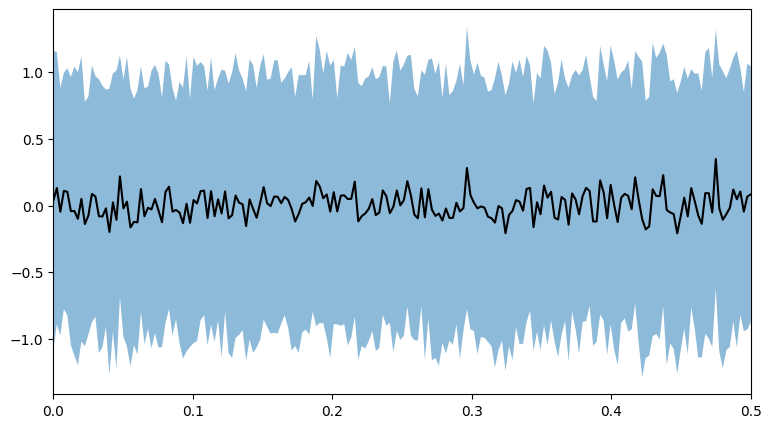

In [4]:
# This is an example of plot (random data). You can change it if you want.

## Change the following lines
periodograms = np.random.randn(100, 200)  # shape (n_trials, n_freqs)
freqs = np.linspace(0, 0.5, 200)
##


fig, ax = fig_ax(figsize=(9, 5))

avg = periodograms.mean(axis=0)
std = periodograms.std(axis=0)
ax.plot(freqs, avg, 'k-')
ax.fill_between(freqs, avg-std, avg+std, alpha=0.5)


In [5]:
import os
import numpy as np
import matplotlib.pyplot as plt

# Function to generate Gaussian white noise
def generate_white_noise(N, n_simulations=100, variance=1.0):
    return np.random.normal(0, np.sqrt(variance), (n_simulations, N))

# Function to compute sample autocovariance
def sample_autocovariance(X, N):
    autocovariances = []
    for simulation in X:
        autocov = [np.correlate(simulation, np.roll(simulation, tau), mode='valid')[0] / N for tau in range(N)]
        autocovariances.append(autocov)
    return np.array(autocovariances)

# Function to compute periodogram
def compute_periodogram(X, N):
    periodograms = []
    for simulation in X:
        fft_values = np.fft.fft(simulation) / np.sqrt(N)
        periodogram = np.abs(fft_values[:N // 2])**2
        periodograms.append(periodogram)
    return np.array(periodograms)

# Function to create the 'figures' folder if it doesn't exist
def create_figures_folder():
    if not os.path.exists('figures'):
        os.makedirs('figures')

# Plotting and saving function
def plot_and_save_results(results, N, ylabel, title, filename):
    avg = results.mean(axis=0)
    std = results.std(axis=0)
    x = np.arange(len(avg))  # Time lags for autocovariance or frequencies for periodogram

    plt.figure(figsize=(9, 5))
    plt.plot(x, avg, 'k-')
    plt.fill_between(x, avg - std, avg + std, alpha=0.5)
    plt.title(f'{title} (N={N})')
    plt.xlabel('Time lag (Autocovariance)' if ylabel == 'Autocovariance' else 'Frequency')
    plt.ylabel(ylabel)
    
    # Save figure in the 'figures' folder
    plt.savefig(f'figures/{filename}', bbox_inches='tight')
    plt.close()

# Parameters
N_list = [200, 500, 1000]  # Different N values
n_simulations = 100  # Number of simulations

# Create the 'figures' folder
create_figures_folder()

# Main loop to compute autocovariance and periodogram for each N
for N in N_list:
    white_noise = generate_white_noise(N, n_simulations)

    # Sample autocovariance
    autocovariances = sample_autocovariance(white_noise, N)
    plot_and_save_results(autocovariances, N, 'Autocovariance', 'Sample Autocovariance', f'autocovariance_N{N}.png')

    # Periodogram
    periodograms = compute_periodogram(white_noise, N)
    plot_and_save_results(periodograms, N, 'Power', 'Periodogram', f'periodogram_N{N}.png')

print("Plots saved in the 'figures' folder.")


Plots saved in the 'figures' folder.


## Question 9

In [6]:
# Function to compute Bartlett's estimate
def compute_bartlett(X, N, K):
    section_length = N // K
    bartlett_periodograms = []
    
    for simulation in X:
        avg_periodogram = np.zeros(section_length // 2)
        for k in range(K):
            section = simulation[k * section_length:(k + 1) * section_length]
            fft_values = np.fft.fft(section) / np.sqrt(section_length)
            periodogram = np.abs(fft_values[:section_length // 2])**2
            avg_periodogram += periodogram
        avg_periodogram /= K
        bartlett_periodograms.append(avg_periodogram)
    
    return np.array(bartlett_periodograms)

In [7]:
# Parameters
N_list = [200, 500, 1000]  # Different N values
n_simulations = 100  # Number of simulations
K = 5  # Number of sections for Bartlett's method

# Create the 'figures' folder
if not os.path.exists('figures'):
    os.makedirs('figures')

# Main loop to compute Bartlett periodograms for each N
for N in N_list:
    white_noise = generate_white_noise(N, n_simulations)

    # Bartlett's estimate
    bartlett_periodograms = compute_bartlett(white_noise, N, K)
    plot_and_save_results(bartlett_periodograms, N, 'Power', 'Bartlett Periodogram', f'bartlett_periodogram_N{N}.png')

print("Bartlett periodograms saved in the 'figures' folder.")

Bartlett periodograms saved in the 'figures' folder.


# Dynamic time warping (DTW)

## Data

This data set consists of signals collected with inertial measurement units (accelerometer+gyroscope), from 230 subjects undergoing a fixed protocol:
- standing still,
- walking 10 m,
- turning around,
- walking back,
- stopping.

In this assignment, we only consider the vertical acceleration of the left foot and all signals are truncated to 20 seconds (as a result, they all have same length). Signals are sampled at 100 Hz.

The measured population is composed of healthy subjects as well as patients with neurological or orthopedic disorders.

The start and end time stamps of thousands of footsteps are available.

The data are part of a larger data set described in [1].

[1] Truong, C., Barrois-Müller, R., Moreau, T., Provost, C., Vienne-Jumeau, A., Moreau, A., Vidal, P.-P., Vayatis, N., Buffat, S., Yelnik, A., Ricard, D., & Oudre, L. (2019). A data set for the study of human locomotion with inertial measurements units. Image Processing On Line (IPOL), 9.

**The task** is to classify footsteps in healthy/non-healthy.

The following cell defines the training set `(X_train, y_train)` and testing set `(X_test, y_test)`.

In [8]:
subset_indexes_train = [95, 619, 441, 149, 951, 803, 214, 34, 37, 630]
subset_indexes_test = [683, 259, 59, 387, 634]

code_list = get_code_list()

X_train = list()  # list of footstep signals
y_train = list()  # list of pathologies (the "labels")

for code in np.take(code_list, subset_indexes_train):
    single_trial = load_human_locomotion_dataset(code)
    signal = single_trial.signal.LAZ.to_numpy()  # keeping only one dimension (from the left sensor)
    steps = single_trial.left_steps
    pathology = single_trial.metadata["PathologyGroup"]
    label = 0 if pathology=="Healthy" else 1  # 0: healthy, 1: non-healthy
    for (start, end) in steps:
        X_train.append(signal[start:end])
        y_train.append(label)

        
X_test = list()  # list of footstep signals
y_test = list()  # list of pathologies (the "labels")

for code in np.take(code_list, subset_indexes_test):
    single_trial = load_human_locomotion_dataset(code)
    signal = single_trial.signal.LAZ.to_numpy()  # keeping only one dimension (from the left sensor)
    steps = single_trial.left_steps
    pathology = single_trial.metadata["PathologyGroup"]
    label = 0 if pathology=="Healthy" else 1  # 0: healthy, 1: non-healthy
    for (start, end) in steps:
        X_test.append(signal[start:end])
        y_test.append(label)

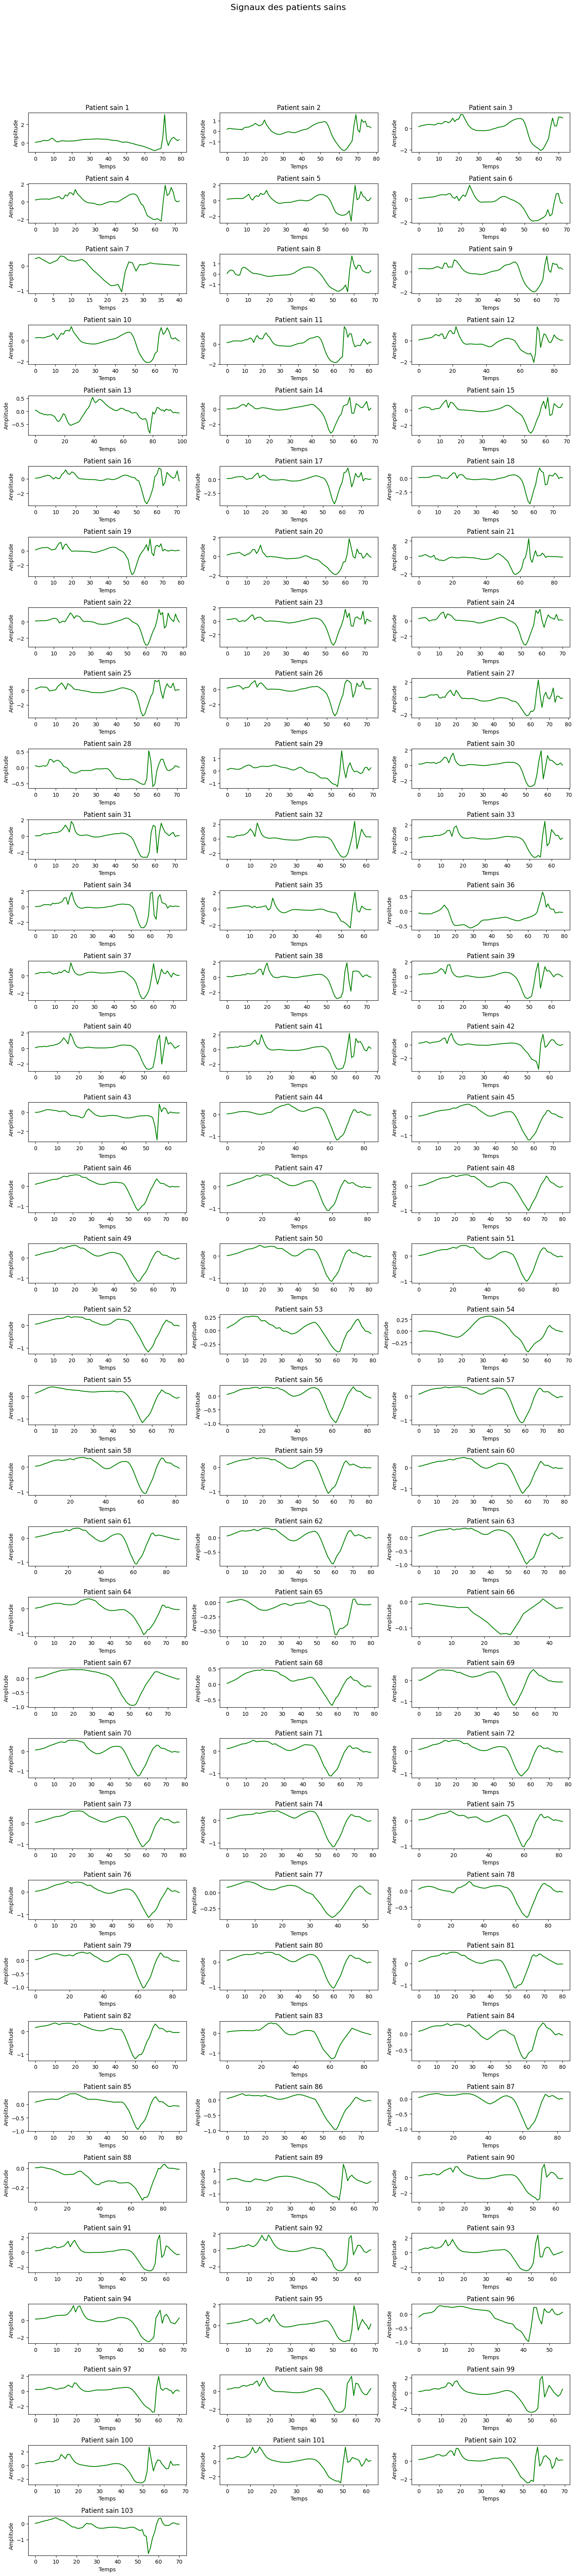

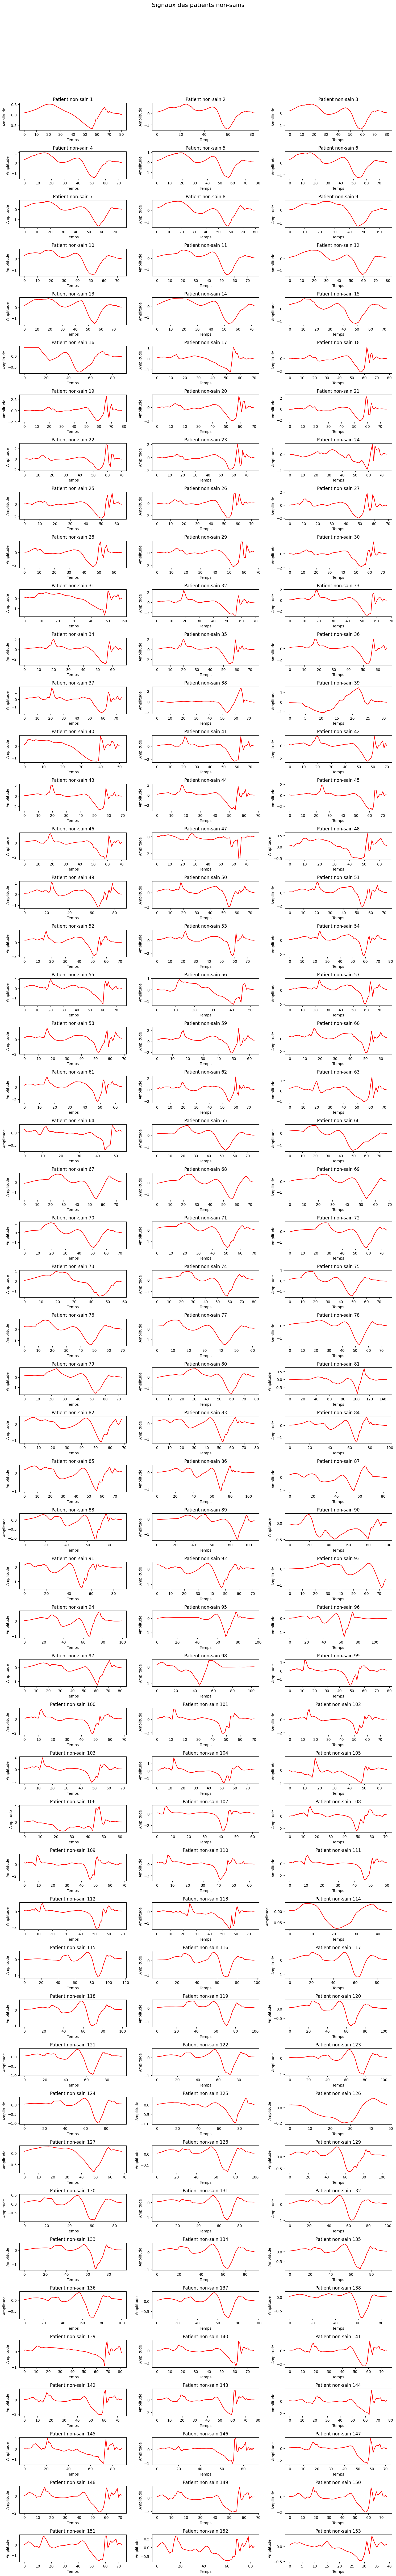

In [27]:
import matplotlib.pyplot as plt

# Séparation des signaux en deux groupes : sains et non-sains
healthy_signals = [signal for signal, label in zip(X_train + X_test, y_train.tolist() + y_test.tolist()) if label == 0]
nonhealthy_signals = [signal for signal, label in zip(X_train + X_test, y_train.tolist() + y_test.tolist()) if label == 1]

# Configuration du nombre de colonnes et de lignes pour l'affichage
n_cols = 3
n_rows_healthy = len(healthy_signals) // n_cols + (len(healthy_signals) % n_cols > 0)
n_rows_nonhealthy = len(nonhealthy_signals) // n_cols + (len(nonhealthy_signals) % n_cols > 0)

# Affichage des signaux sains
fig, axes = plt.subplots(n_rows_healthy, n_cols, figsize=(15, n_rows_healthy * 2))
fig.suptitle("Signaux des patients sains", fontsize=16)
for i, signal in enumerate(healthy_signals):
    row, col = divmod(i, n_cols)
    axes[row, col].plot(signal, color="green")
    axes[row, col].set_title(f"Patient sain {i+1}")
    axes[row, col].set_xlabel("Temps")
    axes[row, col].set_ylabel("Amplitude")

# Masquer les sous-graphiques vides
for j in range(i + 1, n_rows_healthy * n_cols):
    row, col = divmod(j, n_cols)
    axes[row, col].axis('off')

plt.tight_layout(rect=[0, 0.03, 1, 0.95])  # ajustement pour le titre
plt.show()

# Affichage des signaux non-sains
fig, axes = plt.subplots(n_rows_nonhealthy, n_cols, figsize=(15, n_rows_nonhealthy * 2))
fig.suptitle("Signaux des patients non-sains", fontsize=16)
for i, signal in enumerate(nonhealthy_signals):
    row, col = divmod(i, n_cols)
    axes[row, col].plot(signal, color="red")
    axes[row, col].set_title(f"Patient non-sain {i+1}")
    axes[row, col].set_xlabel("Temps")
    axes[row, col].set_ylabel("Amplitude")

# Masquer les sous-graphiques vides
for j in range(i + 1, n_rows_nonhealthy * n_cols):
    row, col = divmod(j, n_cols)
    axes[row, col].axis('off')

plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()


In [25]:
y_train

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1])

Text(0.5, 1.0, 'Footstep signal for the first training sample (label=0)')

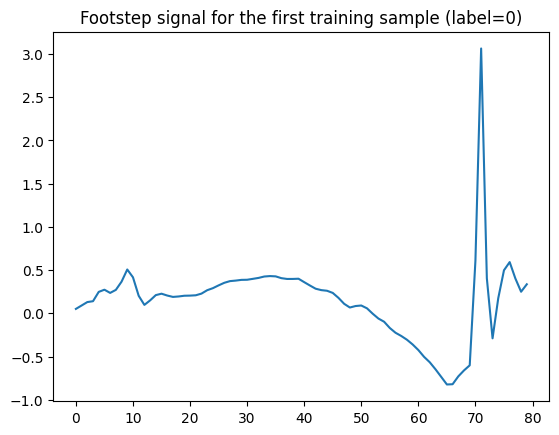

In [24]:
plt.plot(X_train[0], label='Footstep signal')
plt.title(f'Footstep signal for the first training sample (label={y_train[0]})')

Text(0.5, 1.0, 'Footstep signal for the first training sample (label=1)')

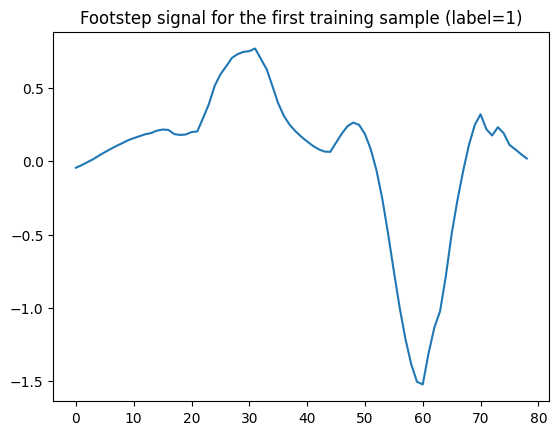

In [26]:
plt.plot(X_train[-1], label='Footstep signal')
plt.title(f'Footstep signal for the first training sample (label={y_train[-1]})')

## Question 10

In [9]:
import numpy as np
from sklearn.metrics import f1_score
from sklearn.model_selection import KFold
from tslearn.neighbors import KNeighborsTimeSeriesClassifier
from tslearn.utils import to_time_series_dataset

# Convert lists to time-series dataset (3D array format expected by tslearn)
X_train_ts = to_time_series_dataset(X_train)
X_test_ts = to_time_series_dataset(X_test)

# Convert labels to numpy arrays
y_train = np.array(y_train)
y_test = np.array(y_test)
y_test = y_test.astype(int)

# Perform k-NN with DTW and 5-fold cross-validation to find the optimal number of neighbors
kf = KFold(n_splits=5, shuffle=True, random_state=42)
n_neighbors_options = [1, 2, 3, 4, 5, 7, 9]  # Testing different values of k
best_n_neighbors = None
best_f1_score = 0

for n_neighbors in n_neighbors_options:
    f1_scores = []
    
    for train_index, val_index in kf.split(X_train_ts):
        X_train_fold, X_val_fold = X_train_ts[train_index], X_train_ts[val_index]
        y_train_fold, y_val_fold = y_train[train_index], y_train[val_index]
        
        knn = KNeighborsTimeSeriesClassifier(n_neighbors=n_neighbors, metric="dtw")
        knn.fit(X_train_fold, y_train_fold)
        
        y_val_pred = knn.predict(X_val_fold)
        f1 = f1_score(y_val_fold, y_val_pred, average='weighted')
        f1_scores.append(f1)
    
    mean_f1_score = np.mean(f1_scores)
    print(f"n_neighbors = {n_neighbors}, F1-score = {mean_f1_score}")
    
    if mean_f1_score > best_f1_score:
        best_f1_score = mean_f1_score
        best_n_neighbors = n_neighbors

print(f"Optimal number of neighbors: {best_n_neighbors}")
print(f"Best F1-score (cross-validated): {best_f1_score}")

knn = KNeighborsTimeSeriesClassifier(n_neighbors=best_n_neighbors, metric="dtw")
knn.fit(X_train_ts, y_train)

y_test_pred = knn.predict(X_test_ts)
f1_test_score = f1_score(y_test, y_test_pred, average='weighted')

print(f"F-score on the test set: {f1_test_score}")


d:\Documents\Scolaires\MVA\venv\Lib\site-packages\tslearn\bases\bases.py:15: UserWarning: h5py not installed, hdf5 features will not be supported.
Install h5py to use hdf5 features: http://docs.h5py.org/
  warn(h5py_msg)


n_neighbors = 1, F1-score = 0.8803531283906538
n_neighbors = 2, F1-score = 0.8747755906674314
n_neighbors = 3, F1-score = 0.8807410733326181
n_neighbors = 4, F1-score = 0.875102316392639
n_neighbors = 5, F1-score = 0.8753455772229086
n_neighbors = 7, F1-score = 0.8640675541462801
n_neighbors = 9, F1-score = 0.828084818789683
Optimal number of neighbors: 3
Best F1-score (cross-validated): 0.8807410733326181
F-score on the test set: 0.4474294142435735


## Question 11

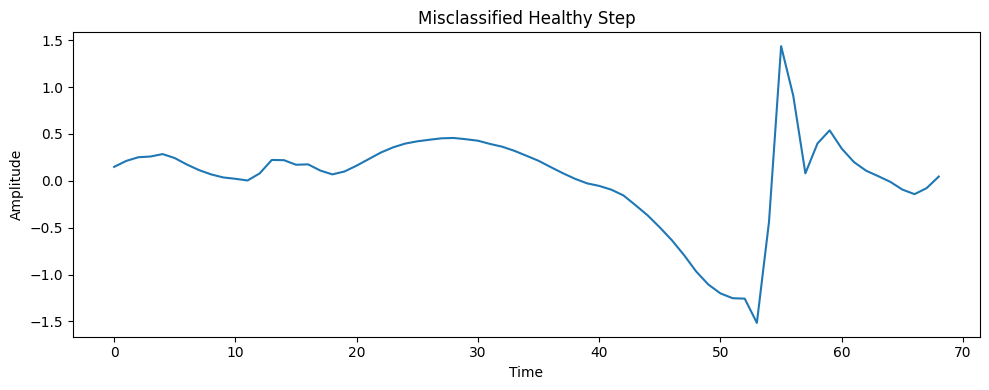

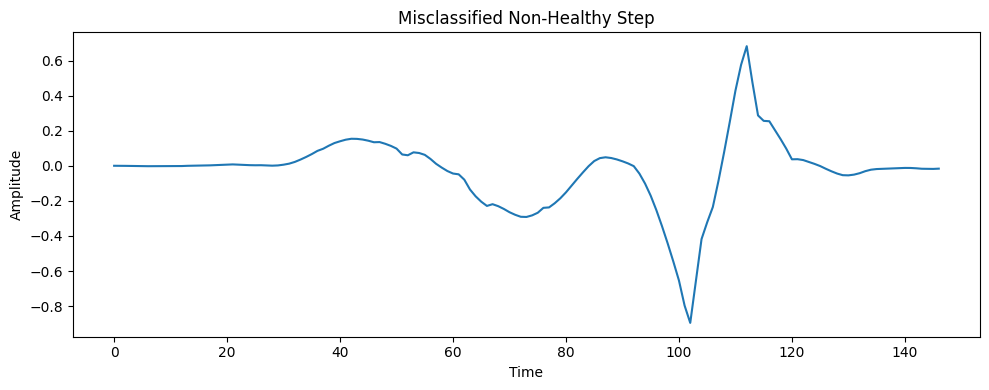

In [10]:
misclassified_indices = np.where(y_test != y_test_pred)[0]

misclassified_healthy_indices = [idx for idx in misclassified_indices if y_test[idx] == 0]
if misclassified_healthy_indices:
    idx_healthy = misclassified_healthy_indices[0]
    step_healthy = X_test[idx_healthy]
else:
    print("No misclassified healthy steps found.")
    idx_healthy = None

misclassified_nonhealthy_indices = [idx for idx in misclassified_indices if y_test[idx] == 1]
if misclassified_nonhealthy_indices:
    idx_nonhealthy = misclassified_nonhealthy_indices[0]
    step_nonhealthy = X_test[idx_nonhealthy]
else:
    print("No misclassified non-healthy steps found.")
    idx_nonhealthy = None

import matplotlib.pyplot as plt
import os

if not os.path.exists('figures'):
    os.makedirs('figures')

if idx_healthy is not None:
    plt.figure(figsize=(10, 4))
    plt.plot(step_healthy)
    plt.title("Misclassified Healthy Step")
    plt.xlabel("Time")
    plt.ylabel("Amplitude")
    plt.tight_layout()
    plt.savefig("figures/misclassified_healthy_step.png")
    plt.show()

if idx_nonhealthy is not None:
    plt.figure(figsize=(10, 4))
    plt.plot(step_nonhealthy)
    plt.title("Misclassified Non-Healthy Step")
    plt.xlabel("Time")
    plt.ylabel("Amplitude")
    plt.tight_layout()
    plt.savefig("figures/misclassified_nonhealthy_step.png")
    plt.show()


## BONUS

Display of the signals respectively well classified and misclassified.

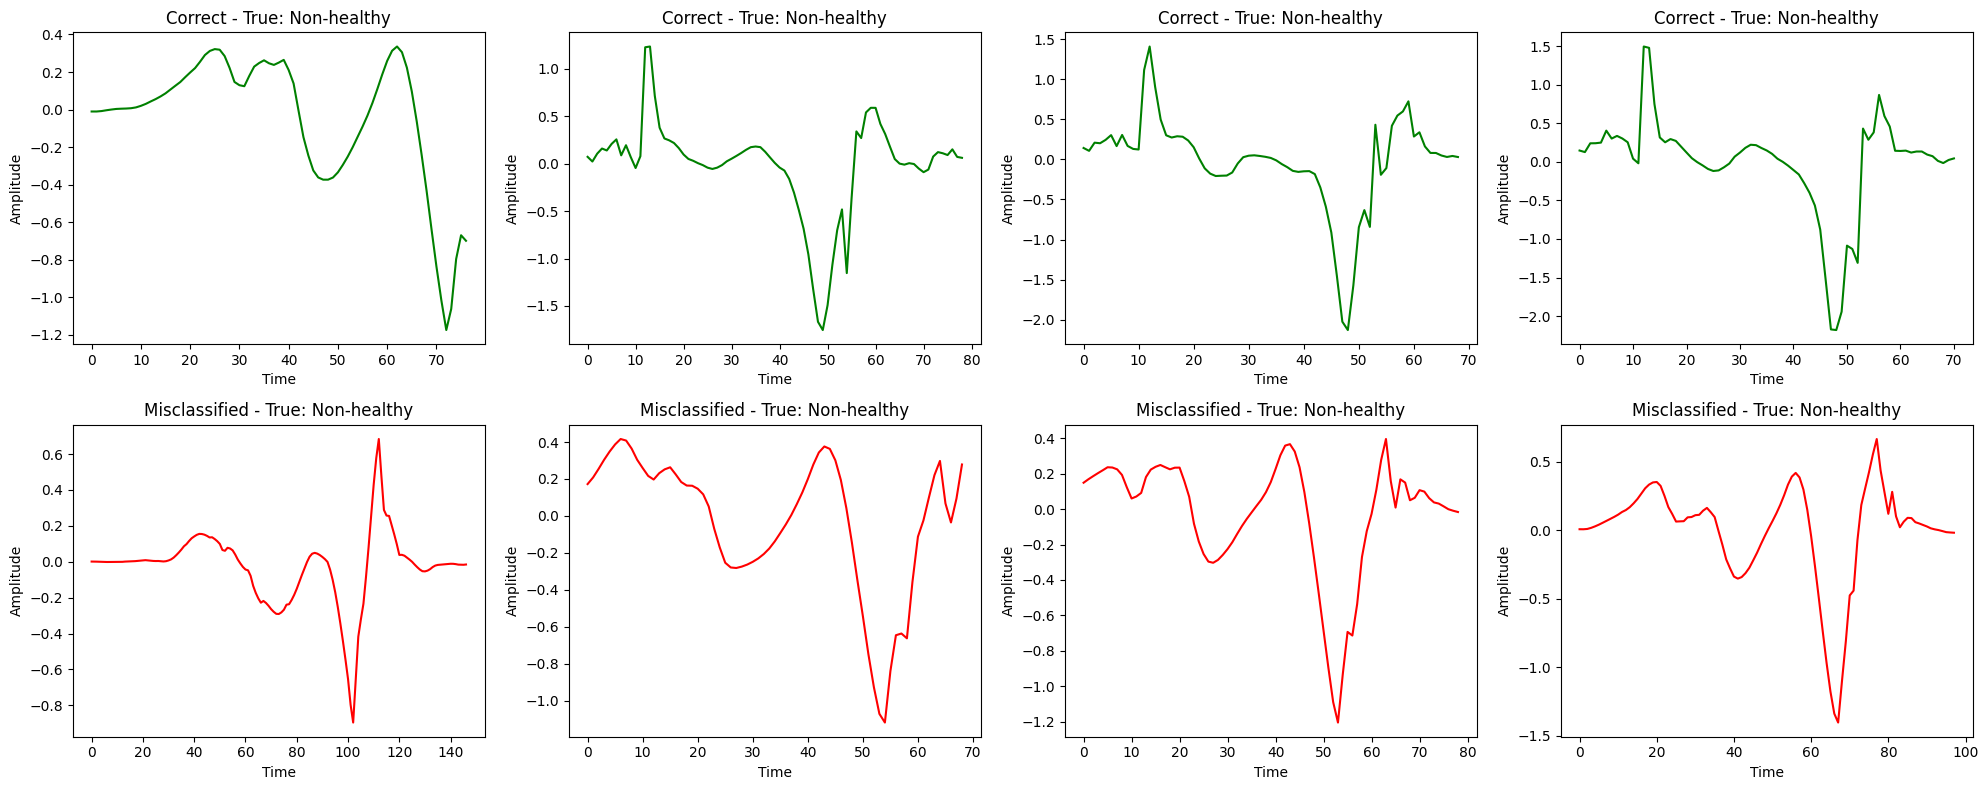

In [28]:
import matplotlib.pyplot as plt

correctly_classified_indices = np.where(y_test == y_test_pred)[0][:4]
misclassified_indices = np.where(y_test != y_test_pred)[0][:4]

fig, axes = plt.subplots(2, max(len(correctly_classified_indices), len(misclassified_indices)), figsize=(20, 8))

for i, idx in enumerate(correctly_classified_indices):
    step_signal = X_test[idx]
    axes[0, i].plot(step_signal, color="green")
    axes[0, i].set_title(f"Correct - True: {'Healthy' if y_test[idx] == 0 else 'Non-healthy'}")

for i, idx in enumerate(misclassified_indices):
    step_signal = X_test[idx]
    axes[1, i].plot(step_signal, color="red")
    axes[1, i].set_title(f"Misclassified - True: {'Healthy' if y_test[idx] == 0 else 'Non-healthy'}")

for ax in axes.flatten():
    ax.set_xlabel("Time")
    ax.set_ylabel("Amplitude")

plt.tight_layout()
plt.show()


Class are not banlanced the same in the training and testing sets.

In [18]:
y_train.sum()/len(y_train)

np.float64(0.47619047619047616)

In [19]:
y_test.sum()/len(y_test)

np.float64(0.8295454545454546)

In [21]:
y_test_pred.sum()/len(y_test_pred)

np.float64(0.45454545454545453)